## Training denoising autoencoder for peak evaluation

The training data are from [Schulze's study](https://www.mdpi.com/2218-1989/10/4/162). The manually picked true peaks are treated as positive samples, which are used for training the denoising autoencoder.

### Import packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

### Data preparation

We transformed the training data in advance, where X is the matrix of ROIs and Y is the corresponding labels. Here we load the data directly.

In [2]:
x = np.load('data/X.npy')
y = np.load('data/Y.npy')

We only keep the positive samples for training, which will assist the denoising autoencoder grasp the common characteristics of the true peaks. Meanwhile, we remove the rows with all 0.

In [3]:
sums = np.sum(x, axis = 1)
keep = np.where(np.logical_and(y == 1, sums > 0))[0]
x = x[keep, :]
y = y[keep]

Then, scale the intensity to 0 - 1.

In [4]:
for i in range(x.shape[0]):
    x[i,:] = x[i,:] / np.max(x[i,:])

### Preprocessing

In [5]:
# train test split
x_train, x_test, _, _ = train_test_split(x, y, test_size=0.1)

# reshape
length = x_train.shape[1]
x_train = np.reshape(x_train, [-1, length, 1])
x_test = np.reshape(x_test, [-1, length, 1])

### Define random noise layer

In [6]:
input_shape = (length, 1)

class RandomNoise(keras.layers.Layer):
    def call(self, inputs):
        noise = K.random_normal(shape=tf.shape(inputs), stddev = 0.2)
        outputs = K.in_train_phase(inputs + noise, inputs)
        return (outputs) / tf.keras.backend.max(outputs)

### Model construction

In [7]:
# encoder
inputs = keras.layers.Input(shape=input_shape,name='encoder_input')

x = inputs
x = RandomNoise()(x)
# x = keras.layers.GaussianNoise(0.1)(x, training = True)
# x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Conv1D(8, 5, activation='relu')(x)
x = keras.layers.Conv1D(4, 5, activation='relu')(x)
x = keras.layers.Flatten()(x)
latent = keras.layers.Dense(64, name='latent_vector')(x)
encoder = keras.Model(inputs,latent,name='encoder')

# decoder
latent_inputs = keras.layers.Input(shape=(64,),name='decoder_input')
x = keras.layers.Dense(32, activation='relu')(latent_inputs)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dense(length, activation='linear')(x)
outputs = keras.layers.Reshape((length, 1))(x)
decoder = keras.Model(latent_inputs,outputs,name='decoder')

# model
autoencoder = keras.Model(inputs, decoder(encoder(inputs)),name='autoencoder')
autoencoder.compile(loss='mse',optimizer='adam')
autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=10)
# autoencoder.save('model/denoising_autoencoder.pkl')

Epoch 1/10
2798/2798 [==============================] - 10s 3ms/step - loss: 0.0150 - val_loss: 0.0245
Epoch 2/10
2798/2798 [==============================] - 7s 3ms/step - loss: 0.0101 - val_loss: 0.0283
Epoch 3/10
2798/2798 [==============================] - 7s 3ms/step - loss: 0.0096 - val_loss: 0.0294
Epoch 4/10
2798/2798 [==============================] - 7s 3ms/step - loss: 0.0094 - val_loss: 0.0247
Epoch 5/10
2798/2798 [==============================] - 7s 3ms/step - loss: 0.0092 - val_loss: 0.0201
Epoch 6/10
2798/2798 [==============================] - 8s 3ms/step - loss: 0.0092 - val_loss: 0.0191
Epoch 7/10
2798/2798 [==============================] - 9s 3ms/step - loss: 0.0091 - val_loss: 0.0239
Epoch 8/10
2798/2798 [==============================] - 9s 3ms/step - loss: 0.0090 - val_loss: 0.0229
Epoch 9/10
2798/2798 [==============================] - 9s 3ms/step - loss: 0.0089 - val_loss: 0.0164
Epoch 10/10
2798/2798 [==============================] - 9s 3ms/step - loss: 0.00

### Predict and visualize examples

311/311 [==============================] - 0s 1ms/step


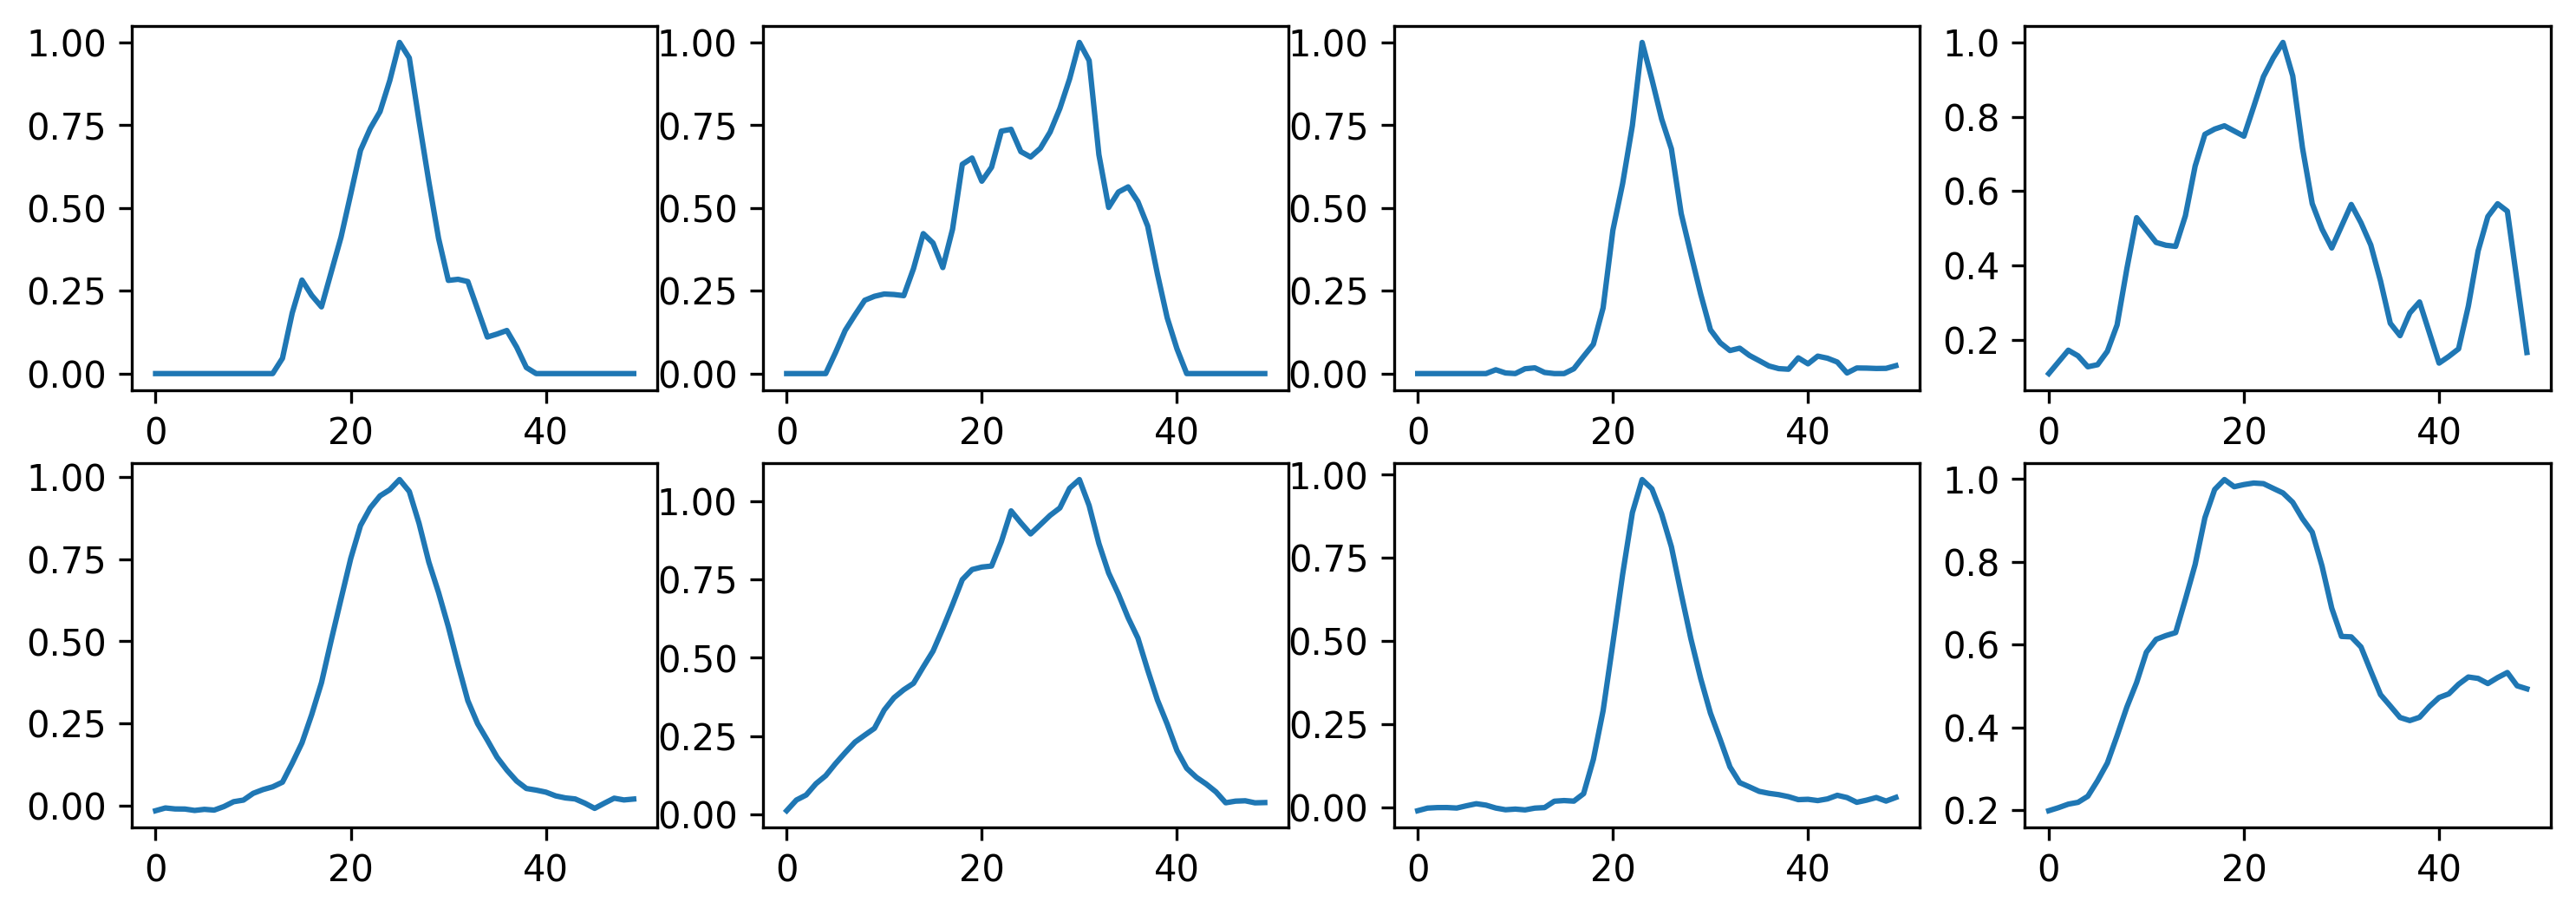

In [8]:
# predict
x_decoded = autoencoder.predict(x_test)
x_test = np.reshape(x_test, [-1, length])
x_decoded = np.reshape(x_decoded, [-1, length])

# plot
plt.figure(dpi = 300, figsize = (12,4))
plt.subplot(241)
plt.plot(x_test[1,:])
plt.subplot(242)
plt.plot(x_test[2,:])
plt.subplot(243)
plt.plot(x_test[3,:])
plt.subplot(244)
plt.plot(x_test[4,:])
plt.subplot(245)
plt.plot(x_decoded[1,:])
plt.subplot(246)
plt.plot(x_decoded[2,:])
plt.subplot(247)
plt.plot(x_decoded[3,:])
plt.subplot(248)
plt.plot(x_decoded[4,:])